# IMPORT & SPLIT

In [2]:
using CSV, DataFrames, Statistics, Dates, Gadfly, LinearAlgebra, Distributions, Random, ScikitLearn, GLM, Plots

In [3]:
x_train = CSV.read("./data/new datasets/precipitation_daily_max/x_train.csv");
y_train = CSV.read("./data/new datasets/precipitation_daily_max/y_train.csv");
x_pred = CSV.read("./data/new datasets/precipitation_daily_max/x_pred.csv");

# PLOT

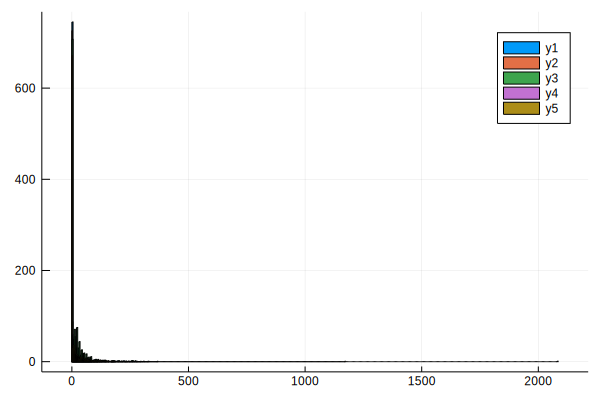

In [4]:
histogram(convert(Matrix, x_train[:, Not(:date)]))

We can observe that most data is skewed towards 0cm with some extreme cases over 2000cm (outliers)

we need to preprocess the data with a function to reduce this gap

$ f(x) = ln(x+1) $

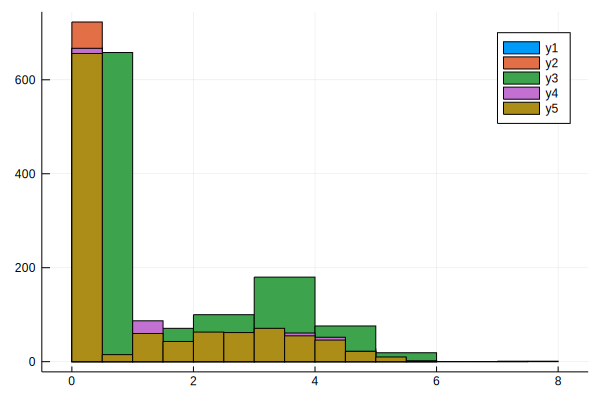

,variable,mean,std,min,q25,median,q75,max
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,x1,1.17901,1.63345,0.0,0.0,0.0,2.56495,7.64156
2,x2,1.05566,1.58641,0.0,0.0,0.0,2.3979,5.69036
3,x3,1.27171,1.68427,0.0,0.0,0.0,2.99573,5.78996
4,x4,1.13171,1.58496,0.0,0.0,0.0,2.3979,5.90536
5,x5,1.14605,1.57803,0.0,0.0,0.0,2.3979,7.06647


In [5]:
x_values = DataFrame([log.(col.+1) for col = eachcol(x_train[:, Not(:date)])])
display(histogram(convert(Matrix, x_values)))
display(describe(x_values, :mean, :std, :min, :q25, :median, :q75, :max))

We will try regression without normalisation

Intuition guides us to believe that the precipitations are correlated, but we will avoid PCA so that the model learns on it's own what meteoroligic stations are important for what gutter

# Logistic Regression

for 1st ouvrage only

In [ ]:
@sk_import linear_model: LogisticRegression
model = LogisticRegression(
    penalty="l2",
    random_state=234, # chosen by random dice roll, thus truly random
)
x = convert(Matrix, x_train)
y = convert(Matrix, y_train)
ScikitLearn.fit!(model, x, y)